In [1]:
# !pip install progressbar
# !pip install prettytable
# !pip install tensorboardX

Source


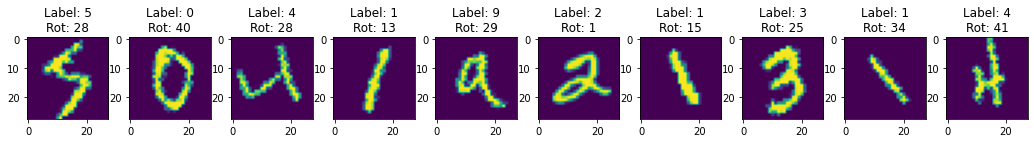

Sub Target #1


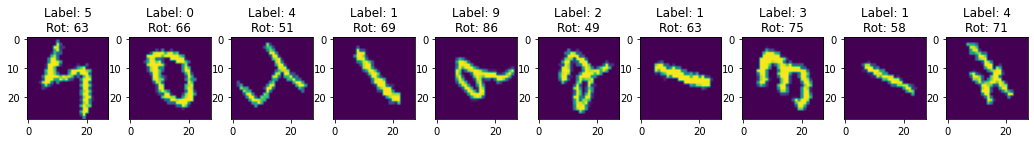

Sub Target #2


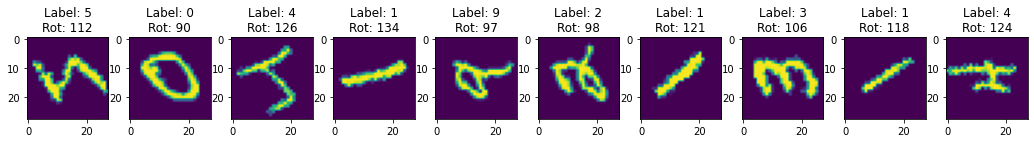

Sub Target #3


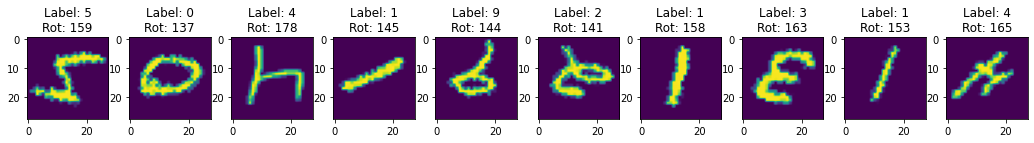

Sub Target #4


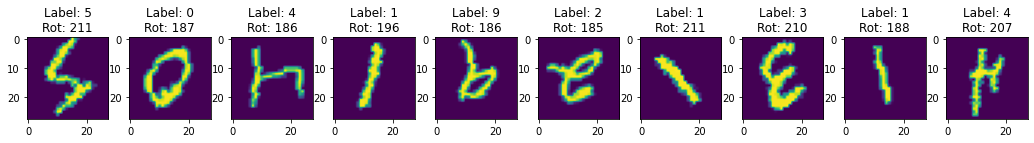

Sub Target #5


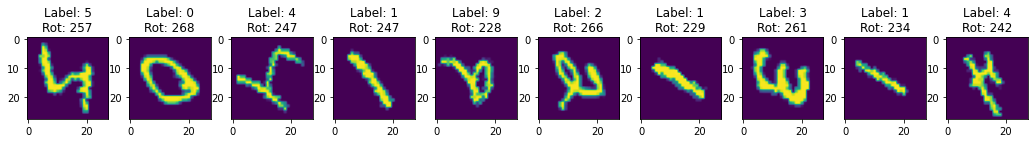

Sub Target #6


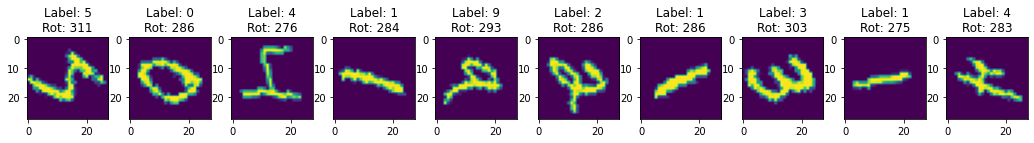

Sub Target #7


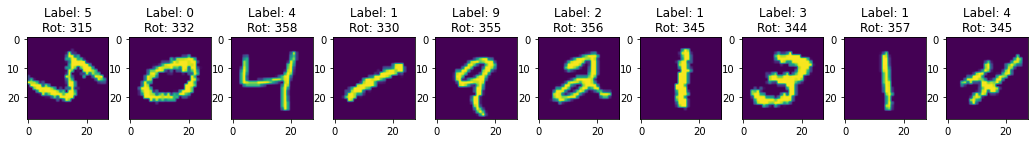

In [2]:
"""
Rotating MNIST dataset
Domain: anti-clockwise rotating angle (theta)
Source domains: theta in (0, 45 degree)
    Amount: 60000
Target domains: theta in (45, 360 degree)
    Amount: 60000 * 7
"""

"""
Download data if needed
"""
from model import download
download()

"""
Visualize the data
"""
import matplotlib.pyplot as plt
from model import RotateMNIST

for i in range(8):
    dataset = RotateMNIST(rotate_angle=(i*45,i*45+45))
    if i == 0:
        dname = 'Source'
    else:
        dname = f'Sub Target #{i}'
    print(dname)
    fig, ax = plt.subplots(1, 10, figsize=(18,1.5))
    for j in range(10):
        img, label, angle, _ = dataset[j]
        angle = angle[0] * 360
        ax[j].imshow(img[0])
        ax[j].set_title(f'Label: {label}\nRot: {angle:.0f}')
    plt.show()
    plt.close()

In [3]:
"""
Configurations
"""
%load_ext autoreload
%autoreload 2

from easydict import EasyDict
from model import set_default_args, print_args
from model import SO, ADDA, DANN, CUA, CIDA, PCIDA
from torch.utils.data import DataLoader

opt = EasyDict()
# choose the method from ["CIDA", "PCIDA", "SO", "ADDA", "DANN" "CUA"]
opt.model = "CIDA"
# choose run on which device ["cuda", "cpu"]
opt.device = "cuda"
set_default_args(opt)
print_args(opt)
# build dataset and data loader
dataset = RotateMNIST(rotate_angle=(0, 360))
train_dataloader = DataLoader(
    dataset=dataset,
    shuffle=True,
    batch_size=opt.batch_size,
    num_workers=4,
)
test_dataloader = DataLoader(
    dataset=dataset,
    shuffle=True,
    batch_size=opt.batch_size,
    num_workers=4,
)
# build model
model_pool = {
    'SO': SO,
    'CIDA': CIDA,
    'PCIDA': PCIDA,
    'ADDA': ADDA,
    'DANN': DANN,
    'CUA': CUA,
}
model = model_pool[opt.model](opt)
model = model.to(opt.device)

Traing result will be saved in  ./dump/RotatingMNIST_CIDA
model: CIDA
device: cuda
dropout: 0
nh: 512
nc: 10
nz: 100
num_epoch: 100
batch_size: 100
lr: 0.0002
weight_decay: 0.0005
beta1: 0.9
lambda_gan: 2.0
exp: RotatingMNIST_CIDA
outf: ./dump/RotatingMNIST_CIDA
dim_domain: 1
continual_da: False


In [4]:
"""
Training the model from the scratch
"""
best_acc_target = 0
if not opt.continual_da:
    # Single Step Domain Adaptation
    for epoch in range(opt.num_epoch):
        model.learn(epoch, train_dataloader)
        if (epoch + 1) % 10 == 0:
            acc_target = model.eval_mnist(test_dataloader)
            if acc_target > best_acc_target:
                print('Best acc target. saved.')
                model.save()
else:
    # continual DA training
    continual_dataset = ContinousRotateMNIST()

    print('===> pretrain the classifer')
    model.prepare_trainer(init=True)
    for epoch in range(opt.num_epoch_pre):
        model.learn(epoch, train_dataloader, init=True)
        if (epoch + 1) % 10 == 0:
            model.eval_mnist(test_dataloader)
    print('===> start continual DA')
    model.prepare_trainer(init=False)
    for phase in range(opt.num_da_step):
        continual_dataset.set_phase(phase)
        print(f'Phase {phase}/{opt.num_da_step}')
        print(f'#source {len(continual_dataset.ds_source)} #target {len(continual_dataset.ds_target[phase])} #replay {len(continual_dataset.ds_replay)}')
        continual_dataloader = DataLoader(
            dataset=continual_dataset,
            shuffle=True,
            batch_size=opt.batch_size,
            num_workers=4,
        )
        for epoch in range(opt.num_epoch_sub):
            model.learn(epoch, continual_dataloader, init=False)
            if (epoch + 1) % 10 == 0:
                model.eval_mnist(test_dataloader)

        target_dataloader = DataLoader(
            dataset=continual_dataset.ds_target[phase],
            shuffle=True,
            batch_size=opt.batch_size,
            num_workers=4,
        )
        acc_target = model.eval_mnist(test_dataloader)
        if acc_target > best_acc_target:
            print('Best acc target. saved.')
            model.save()
        data_tuple = model.gen_data_tuple(target_dataloader)
        continual_dataset.ds_replay.update(data_tuple)  


/home/hao/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/nn/functional.py:3447: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/home/hao/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/nn/functional.py:3384: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


[Train][0] Loss: D 0.105 E_gan -0.091 E_pred 0.693
[Train][0] Acc: source 0.813 (5959.0/7332) target 0.403 (21190.0/52668)


[Train][1] Loss: D 0.077 E_gan -0.073 E_pred 0.214
[Train][1] Acc: source 0.940 (6895.0/7332) target 0.456 (23980.0/52668)


[Train][2] Loss: D 0.079 E_gan -0.076 E_pred 0.168
[Train][2] Acc: source 0.950 (6963.0/7332) target 0.479 (25234.0/52668)


[Train][3] Loss: D 0.078 E_gan -0.076 E_pred 0.140
[Train][3] Acc: source 0.960 (7036.0/7332) target 0.501 (26378.0/52668)


[Train][4] Loss: D 0.083 E_gan -0.081 E_pred 0.121
[Train][4] Acc: source 0.966 (7086.0/7332) target 0.550 (28943.0/52668)


[Train][5] Loss: D 0.083 E_gan -0.081 E_pred 0.109
[Train][5] Acc: source 0.970 (7113.0/7332) target 0.529 (27873.0/52668)


[Train][6] Loss: D 0.084 E_gan -0.082 E_pred 0.106
[Train][6] Acc: source 0.969 (7107.0/7332) target 0.546 (28746.0/52668)


[Train][7] Loss: D 0.086 E_gan -0.084 E_pred 0.106
[Train][7] Acc: source 0.967 (7093.0/7332) target 0.557 (29313.0/52668)


[Train][8] Loss: D 0.085 E_gan -0.083 E_pred 0.084
[Train][8] Acc: source 0.974 (7145.0/7332) target 0.551 (29018.0/52668)


[Train][9] Loss: D 0.083 E_gan -0.081 E_pred 0.106
[Train][9] Acc: source 0.970 (7111.0/7332) target 0.532 (28040.0/52668)



Eval MNIST: [0.973 0.788 0.323 0.318 0.385 0.384 0.502 0.849] src: 0.973 tgt:0.507
Best acc target. saved.


[Train][10] Loss: D 0.083 E_gan -0.081 E_pred 0.098
[Train][10] Acc: source 0.970 (7110.0/7332) target 0.544 (28647.0/52668)


[Train][11] Loss: D 0.085 E_gan -0.083 E_pred 0.089
[Train][11] Acc: source 0.975 (7149.0/7332) target 0.571 (30064.0/52668)


[Train][12] Loss: D 0.085 E_gan -0.083 E_pred 0.085
[Train][12] Acc: source 0.974 (7141.0/7332) target 0.562 (29616.0/52668)


[Train][13] Loss: D 0.085 E_gan -0.084 E_pred 0.081
[Train][13] Acc: source 0.977 (7161.0/7332) target 0.553 (29140.0/52668)


[Train][14] Loss: D 0.086 E_gan -0.085 E_pred 0.101
[Train][14] Acc: source 0.970 (7110.0/7332) target 0.584 (30771.0/52668)


[Train][15] Loss: D 0.084 E_gan -0.083 E_pred 0.136
[Train][15] Acc: source 0.959 (7034.0/7332) target 0.583 (30702.0/52668)


[Train][16] Loss: D 0.085 E_gan -0.083 E_pred 0.128
[Train][16] Acc: source 0.960 (7038.0/7332) target 0.622 (32755.0/52668)


[Train][17] Loss: D 0.085 E_gan -0.084 E_pred 0.110
[Train][17] Acc: source 0.968 (7098.0/7332) target 0.633 (33325.0/52668)


[Train][18] Loss: D 0.084 E_gan -0.083 E_pred 0.109
[Train][18] Acc: source 0.969 (7105.0/7332) target 0.627 (33018.0/52668)


[Train][19] Loss: D 0.086 E_gan -0.084 E_pred 0.102
[Train][19] Acc: source 0.968 (7095.0/7332) target 0.643 (33880.0/52668)



Eval MNIST: [0.974 0.804 0.515 0.456 0.397 0.542 0.871 0.953] src: 0.974 tgt:0.648
Best acc target. saved.


[Train][20] Loss: D 0.087 E_gan -0.085 E_pred 0.102
[Train][20] Acc: source 0.970 (7113.0/7332) target 0.657 (34594.0/52668)


[Train][21] Loss: D 0.087 E_gan -0.086 E_pred 0.100
[Train][21] Acc: source 0.970 (7110.0/7332) target 0.662 (34859.0/52668)


[Train][22] Loss: D 0.087 E_gan -0.085 E_pred 0.094
[Train][22] Acc: source 0.973 (7135.0/7332) target 0.672 (35408.0/52668)


[Train][23] Loss: D 0.085 E_gan -0.084 E_pred 0.100
[Train][23] Acc: source 0.971 (7120.0/7332) target 0.676 (35590.0/52668)


[Train][24] Loss: D 0.083 E_gan -0.082 E_pred 0.111
[Train][24] Acc: source 0.968 (7094.0/7332) target 0.664 (34951.0/52668)


[Train][25] Loss: D 0.084 E_gan -0.082 E_pred 0.081
[Train][25] Acc: source 0.975 (7152.0/7332) target 0.676 (35579.0/52668)


[Train][26] Loss: D 0.083 E_gan -0.082 E_pred 0.108
[Train][26] Acc: source 0.967 (7091.0/7332) target 0.676 (35611.0/52668)


[Train][27] Loss: D 0.084 E_gan -0.083 E_pred 0.082
[Train][27] Acc: source 0.974 (7143.0/7332) target 0.699 (36817.0/52668)


[Train][28] Loss: D 0.083 E_gan -0.081 E_pred 0.087
[Train][28] Acc: source 0.974 (7138.0/7332) target 0.704 (37097.0/52668)


[Train][29] Loss: D 0.083 E_gan -0.082 E_pred 0.102
[Train][29] Acc: source 0.968 (7100.0/7332) target 0.718 (37836.0/52668)



Eval MNIST: [0.975 0.842 0.638 0.609 0.523 0.638 0.868 0.945] src: 0.975 tgt:0.723
Best acc target. saved.


[Train][30] Loss: D 0.082 E_gan -0.081 E_pred 0.096
[Train][30] Acc: source 0.969 (7107.0/7332) target 0.717 (37757.0/52668)


[Train][31] Loss: D 0.083 E_gan -0.081 E_pred 0.099
[Train][31] Acc: source 0.972 (7130.0/7332) target 0.706 (37198.0/52668)


[Train][32] Loss: D 0.084 E_gan -0.083 E_pred 0.091
[Train][32] Acc: source 0.971 (7123.0/7332) target 0.711 (37460.0/52668)


[Train][33] Loss: D 0.087 E_gan -0.086 E_pred 0.095
[Train][33] Acc: source 0.974 (7142.0/7332) target 0.716 (37693.0/52668)


[Train][34] Loss: D 0.086 E_gan -0.085 E_pred 0.069
[Train][34] Acc: source 0.981 (7191.0/7332) target 0.738 (38855.0/52668)


[Train][35] Loss: D 0.086 E_gan -0.085 E_pred 0.064
[Train][35] Acc: source 0.979 (7180.0/7332) target 0.740 (38976.0/52668)


[Train][36] Loss: D 0.087 E_gan -0.086 E_pred 0.073
[Train][36] Acc: source 0.979 (7175.0/7332) target 0.759 (39982.0/52668)


[Train][37] Loss: D 0.087 E_gan -0.086 E_pred 0.081
[Train][37] Acc: source 0.977 (7163.0/7332) target 0.776 (40864.0/52668)


[Train][38] Loss: D 0.089 E_gan -0.088 E_pred 0.075
[Train][38] Acc: source 0.977 (7167.0/7332) target 0.779 (41029.0/52668)


[Train][39] Loss: D 0.089 E_gan -0.088 E_pred 0.081
[Train][39] Acc: source 0.976 (7156.0/7332) target 0.788 (41504.0/52668)



Eval MNIST: [0.981 0.903 0.76  0.742 0.659 0.74  0.896 0.956] src: 0.981 tgt:0.808
Best acc target. saved.


[Train][40] Loss: D 0.089 E_gan -0.088 E_pred 0.069
[Train][40] Acc: source 0.980 (7182.0/7332) target 0.795 (41863.0/52668)


[Train][41] Loss: D 0.089 E_gan -0.089 E_pred 0.061
[Train][41] Acc: source 0.980 (7185.0/7332) target 0.805 (42386.0/52668)


[Train][42] Loss: D 0.089 E_gan -0.089 E_pred 0.067
[Train][42] Acc: source 0.980 (7188.0/7332) target 0.807 (42487.0/52668)


[Train][43] Loss: D 0.089 E_gan -0.088 E_pred 0.059
[Train][43] Acc: source 0.981 (7196.0/7332) target 0.807 (42515.0/52668)


[Train][44] Loss: D 0.089 E_gan -0.089 E_pred 0.068
[Train][44] Acc: source 0.978 (7172.0/7332) target 0.805 (42380.0/52668)


[Train][45] Loss: D 0.089 E_gan -0.089 E_pred 0.064
[Train][45] Acc: source 0.981 (7190.0/7332) target 0.816 (42950.0/52668)


[Train][46] Loss: D 0.089 E_gan -0.089 E_pred 0.065
[Train][46] Acc: source 0.981 (7190.0/7332) target 0.807 (42504.0/52668)


[Train][47] Loss: D 0.089 E_gan -0.088 E_pred 0.064
[Train][47] Acc: source 0.981 (7193.0/7332) target 0.798 (42002.0/52668)


[Train][48] Loss: D 0.089 E_gan -0.088 E_pred 0.057
[Train][48] Acc: source 0.983 (7206.0/7332) target 0.804 (42357.0/52668)


[Train][49] Loss: D 0.089 E_gan -0.089 E_pred 0.061
[Train][49] Acc: source 0.983 (7205.0/7332) target 0.808 (42559.0/52668)



Eval MNIST: [0.987 0.904 0.734 0.745 0.706 0.802 0.922 0.96 ] src: 0.987 tgt:0.825
Best acc target. saved.


[Train][50] Loss: D 0.090 E_gan -0.090 E_pred 0.068
[Train][50] Acc: source 0.978 (7171.0/7332) target 0.812 (42753.0/52668)


[Train][51] Loss: D 0.090 E_gan -0.090 E_pred 0.061
[Train][51] Acc: source 0.982 (7201.0/7332) target 0.824 (43405.0/52668)


[Train][52] Loss: D 0.090 E_gan -0.089 E_pred 0.051
[Train][52] Acc: source 0.985 (7221.0/7332) target 0.819 (43108.0/52668)


[Train][53] Loss: D 0.090 E_gan -0.090 E_pred 0.055
[Train][53] Acc: source 0.984 (7214.0/7332) target 0.825 (43429.0/52668)


[Train][54] Loss: D 0.089 E_gan -0.089 E_pred 0.048
[Train][54] Acc: source 0.986 (7230.0/7332) target 0.822 (43276.0/52668)


[Train][55] Loss: D 0.090 E_gan -0.089 E_pred 0.061
[Train][55] Acc: source 0.984 (7216.0/7332) target 0.823 (43309.0/52668)


[Train][56] Loss: D 0.090 E_gan -0.089 E_pred 0.049
[Train][56] Acc: source 0.985 (7223.0/7332) target 0.821 (43249.0/52668)


[Train][57] Loss: D 0.091 E_gan -0.090 E_pred 0.062
[Train][57] Acc: source 0.981 (7196.0/7332) target 0.825 (43449.0/52668)


[Train][58] Loss: D 0.090 E_gan -0.090 E_pred 0.057
[Train][58] Acc: source 0.983 (7209.0/7332) target 0.824 (43403.0/52668)


[Train][59] Loss: D 0.091 E_gan -0.090 E_pred 0.052
[Train][59] Acc: source 0.985 (7223.0/7332) target 0.825 (43418.0/52668)



Eval MNIST: [0.986 0.885 0.693 0.742 0.688 0.83  0.931 0.963] src: 0.986 tgt:0.819
Best acc target. saved.


[Train][60] Loss: D 0.090 E_gan -0.090 E_pred 0.057
[Train][60] Acc: source 0.982 (7201.0/7332) target 0.827 (43529.0/52668)


[Train][61] Loss: D 0.091 E_gan -0.090 E_pred 0.047
[Train][61] Acc: source 0.987 (7237.0/7332) target 0.845 (44486.0/52668)


[Train][62] Loss: D 0.091 E_gan -0.091 E_pred 0.054
[Train][62] Acc: source 0.985 (7223.0/7332) target 0.844 (44423.0/52668)


[Train][63] Loss: D 0.091 E_gan -0.090 E_pred 0.049
[Train][63] Acc: source 0.986 (7231.0/7332) target 0.838 (44104.0/52668)


[Train][64] Loss: D 0.091 E_gan -0.090 E_pred 0.046
[Train][64] Acc: source 0.987 (7235.0/7332) target 0.838 (44118.0/52668)


[Train][65] Loss: D 0.091 E_gan -0.090 E_pred 0.045
[Train][65] Acc: source 0.986 (7233.0/7332) target 0.836 (44023.0/52668)


[Train][66] Loss: D 0.090 E_gan -0.090 E_pred 0.039
[Train][66] Acc: source 0.989 (7249.0/7332) target 0.850 (44760.0/52668)


[Train][67] Loss: D 0.091 E_gan -0.090 E_pred 0.045
[Train][67] Acc: source 0.987 (7234.0/7332) target 0.835 (43947.0/52668)


[Train][68] Loss: D 0.091 E_gan -0.090 E_pred 0.041
[Train][68] Acc: source 0.988 (7243.0/7332) target 0.841 (44272.0/52668)


[Train][69] Loss: D 0.091 E_gan -0.090 E_pred 0.051
[Train][69] Acc: source 0.985 (7223.0/7332) target 0.829 (43628.0/52668)



Eval MNIST: [0.988 0.911 0.733 0.802 0.71  0.839 0.94  0.965] src: 0.988 tgt:0.843
Best acc target. saved.


[Train][70] Loss: D 0.091 E_gan -0.090 E_pred 0.048
[Train][70] Acc: source 0.988 (7242.0/7332) target 0.836 (44008.0/52668)


[Train][71] Loss: D 0.091 E_gan -0.090 E_pred 0.053
[Train][71] Acc: source 0.984 (7214.0/7332) target 0.840 (44203.0/52668)


[Train][72] Loss: D 0.091 E_gan -0.091 E_pred 0.041
[Train][72] Acc: source 0.989 (7251.0/7332) target 0.834 (43897.0/52668)


[Train][73] Loss: D 0.091 E_gan -0.091 E_pred 0.044
[Train][73] Acc: source 0.987 (7239.0/7332) target 0.831 (43757.0/52668)


[Train][74] Loss: D 0.091 E_gan -0.090 E_pred 0.045
[Train][74] Acc: source 0.987 (7234.0/7332) target 0.840 (44219.0/52668)


[Train][75] Loss: D 0.091 E_gan -0.090 E_pred 0.040
[Train][75] Acc: source 0.988 (7241.0/7332) target 0.840 (44234.0/52668)


[Train][76] Loss: D 0.091 E_gan -0.091 E_pred 0.038
[Train][76] Acc: source 0.989 (7253.0/7332) target 0.836 (44022.0/52668)


[Train][77] Loss: D 0.091 E_gan -0.090 E_pred 0.044
[Train][77] Acc: source 0.989 (7251.0/7332) target 0.831 (43730.0/52668)


[Train][78] Loss: D 0.091 E_gan -0.090 E_pred 0.039
[Train][78] Acc: source 0.990 (7261.0/7332) target 0.823 (43328.0/52668)


[Train][79] Loss: D 0.091 E_gan -0.090 E_pred 0.042
[Train][79] Acc: source 0.988 (7247.0/7332) target 0.831 (43773.0/52668)



Eval MNIST: [0.992 0.92  0.717 0.73  0.687 0.833 0.935 0.961] src: 0.992 tgt:0.826
Best acc target. saved.


[Train][80] Loss: D 0.090 E_gan -0.090 E_pred 0.042
[Train][80] Acc: source 0.989 (7252.0/7332) target 0.834 (43925.0/52668)


[Train][81] Loss: D 0.091 E_gan -0.090 E_pred 0.043
[Train][81] Acc: source 0.988 (7247.0/7332) target 0.829 (43660.0/52668)


[Train][82] Loss: D 0.091 E_gan -0.090 E_pred 0.036
[Train][82] Acc: source 0.990 (7258.0/7332) target 0.834 (43896.0/52668)


[Train][83] Loss: D 0.090 E_gan -0.090 E_pred 0.044
[Train][83] Acc: source 0.988 (7246.0/7332) target 0.833 (43838.0/52668)


[Train][84] Loss: D 0.091 E_gan -0.090 E_pred 0.037
[Train][84] Acc: source 0.989 (7252.0/7332) target 0.833 (43876.0/52668)


[Train][85] Loss: D 0.091 E_gan -0.091 E_pred 0.035
[Train][85] Acc: source 0.989 (7251.0/7332) target 0.836 (44012.0/52668)


[Train][86] Loss: D 0.091 E_gan -0.091 E_pred 0.040
[Train][86] Acc: source 0.989 (7249.0/7332) target 0.838 (44130.0/52668)


[Train][87] Loss: D 0.091 E_gan -0.091 E_pred 0.035
[Train][87] Acc: source 0.989 (7252.0/7332) target 0.838 (44129.0/52668)


[Train][88] Loss: D 0.091 E_gan -0.091 E_pred 0.038
[Train][88] Acc: source 0.988 (7245.0/7332) target 0.835 (43988.0/52668)


[Train][89] Loss: D 0.091 E_gan -0.091 E_pred 0.038
[Train][89] Acc: source 0.989 (7248.0/7332) target 0.835 (43955.0/52668)



Eval MNIST: [0.992 0.91  0.716 0.775 0.766 0.863 0.953 0.968] src: 0.992 tgt:0.85
Best acc target. saved.


[Train][90] Loss: D 0.091 E_gan -0.091 E_pred 0.030
[Train][90] Acc: source 0.991 (7268.0/7332) target 0.841 (44319.0/52668)


[Train][91] Loss: D 0.092 E_gan -0.091 E_pred 0.034
[Train][91] Acc: source 0.990 (7258.0/7332) target 0.839 (44180.0/52668)


[Train][92] Loss: D 0.091 E_gan -0.090 E_pred 0.030
[Train][92] Acc: source 0.992 (7273.0/7332) target 0.848 (44666.0/52668)


[Train][93] Loss: D 0.092 E_gan -0.091 E_pred 0.033
[Train][93] Acc: source 0.991 (7268.0/7332) target 0.855 (45031.0/52668)


[Train][94] Loss: D 0.091 E_gan -0.091 E_pred 0.031
[Train][94] Acc: source 0.991 (7267.0/7332) target 0.844 (44432.0/52668)


[Train][95] Loss: D 0.091 E_gan -0.091 E_pred 0.034
[Train][95] Acc: source 0.991 (7264.0/7332) target 0.845 (44524.0/52668)


[Train][96] Loss: D 0.091 E_gan -0.091 E_pred 0.028
[Train][96] Acc: source 0.992 (7275.0/7332) target 0.847 (44596.0/52668)


[Train][97] Loss: D 0.091 E_gan -0.091 E_pred 0.029
[Train][97] Acc: source 0.991 (7267.0/7332) target 0.847 (44618.0/52668)


[Train][98] Loss: D 0.092 E_gan -0.092 E_pred 0.031
[Train][98] Acc: source 0.992 (7272.0/7332) target 0.855 (45021.0/52668)


[Train][99] Loss: D 0.091 E_gan -0.091 E_pred 0.032
[Train][99] Acc: source 0.990 (7259.0/7332) target 0.848 (44660.0/52668)



Eval MNIST: [0.992 0.9   0.712 0.785 0.762 0.864 0.946 0.964] src: 0.992 tgt:0.848
Best acc target. saved.


In [5]:
"""
Load the pretrained model
"""
model.load()

load model from ./dump/RotatingMNIST_CIDA/model.pth
done!


In [6]:
"""
Print the model result
"""
model.gen_result_table(test_dataloader)

+----------+--------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+
| Accuracy | Source | Target #1 | Target #2 | Target #3 | Target #4 | Target #5 | Target #6 | Target #7 |
+----------+--------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+
| Class 0  |  99.7  |    99.0   |    96.8   |    96.5   |    96.8   |    98.3   |    99.1   |    98.9   |
| Class 1  |  99.8  |    97.2   |    97.4   |    96.1   |    96.5   |    98.5   |    98.9   |    98.9   |
| Class 2  |  99.7  |    90.8   |    64.0   |    68.4   |    66.7   |    81.9   |    97.9   |    93.4   |
| Class 3  |  99.6  |    92.7   |    82.1   |    86.4   |    87.7   |    95.2   |    97.0   |    98.5   |
| Class 4  |  98.6  |    87.1   |    68.0   |    73.5   |    73.2   |    70.2   |    91.8   |    94.3   |
| Class 5  |  99.5  |    89.5   |    73.9   |    74.0   |    71.6   |    79.4   |    94.8   |    96.2   |
| Class 6  |  99.6  |    90.1   |    58.1   | 